# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [33]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [34]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.383880
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *That is the log probability of selecting the right answer randomly which is what this weighting is doing*


In [38]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 6.442214 analytic: 6.442214, relative error: 1.538325e-08
numerical: -0.126401 analytic: -0.126401, relative error: 6.849471e-09
numerical: -2.155030 analytic: -2.155030, relative error: 2.622521e-09
numerical: -1.978650 analytic: -1.978651, relative error: 9.873274e-09
numerical: -2.005063 analytic: -2.005063, relative error: 5.758011e-09
numerical: -4.324634 analytic: -4.324634, relative error: 1.488425e-08
numerical: -2.321169 analytic: -2.321169, relative error: 2.296329e-08
numerical: 0.358792 analytic: 0.358792, relative error: 3.779605e-08
numerical: 0.119442 analytic: 0.119442, relative error: 1.156030e-07
numerical: 2.194289 analytic: 2.194289, relative error: 2.582273e-09
numerical: 0.098328 analytic: 0.098328, relative error: 5.511631e-08
numerical: 0.902516 analytic: 0.902516, relative error: 2.135526e-08
numerical: -1.224661 analytic: -1.224661, relative error: 1.880155e-08
numerical: 1.590358 analytic: 1.590358, relative error: 2.495830e-10
numerical: 2.688067 

In [60]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.383880e+00 computed in 0.143324s
(1, 500)
vectorized loss: 2.383880e+00 computed in 0.010638s
Loss difference: 0.000000
Gradient difference: 0.000000


In [66]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7, 5e-8]
regularization_strengths = [5e4, 1e8]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for rate in learning_rates:
    for reg in regularization_strengths: 
        svm = Softmax()
        print("training @ rate:{}, reg{}".format(rate, reg))
        loss_hist = svm.train(X_train, y_train, learning_rate=rate, reg=reg,
                      num_iters=2500, verbose=True)
        
        y_train_pred = svm.predict(X_train)
        t_a = np.mean(y_train == y_train_pred)
        
        y_val_pred = svm.predict(X_val)
        v_a = np.mean(y_val == y_val_pred)
        
        results[(rate, reg)] = (t_a, v_a)

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
best_val = 0
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)

    if val_accuracy > best_val:
        best_val = val_accuracy
        best_params = (lr, reg)
        
best_softmax = Softmax()        
best_softmax.train(X_train, y_train, learning_rate=best_params[0], reg=best_params[1],
                      num_iters=30000, verbose=True)   
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

training @ rate:1e-07, reg50000.0
iteration 0 / 2500: loss 5.048312
iteration 100 / 2500: loss 3.610269
iteration 200 / 2500: loss 3.640242
iteration 300 / 2500: loss 3.053184
iteration 400 / 2500: loss 3.584032
iteration 500 / 2500: loss 3.080980
iteration 600 / 2500: loss 3.097140
iteration 700 / 2500: loss 3.012624
iteration 800 / 2500: loss 2.991613
iteration 900 / 2500: loss 3.011501
iteration 1000 / 2500: loss 2.916085
iteration 1100 / 2500: loss 2.929866
iteration 1200 / 2500: loss 2.639236
iteration 1300 / 2500: loss 2.673427
iteration 1400 / 2500: loss 2.861677
iteration 1500 / 2500: loss 2.765680
iteration 1600 / 2500: loss 2.588088
iteration 1700 / 2500: loss 2.660254
iteration 1800 / 2500: loss 2.459156
iteration 1900 / 2500: loss 2.323660
iteration 2000 / 2500: loss 2.488897
iteration 2100 / 2500: loss 2.547901
iteration 2200 / 2500: loss 2.492514
iteration 2300 / 2500: loss 2.511467
iteration 2400 / 2500: loss 2.616612
[1 7 9 3 9 1 8 6 8 9]
[9 2 8 3 0 2 0 0 2 3]
training 

KeyboardInterrupt: 

In [68]:
best_softmax = Softmax()        
best_softmax.train(X_train, y_train, learning_rate=5e-8, reg=1e8,
                      num_iters=100000, verbose=True)   


iteration 0 / 100000: loss 6.813301
iteration 100 / 100000: loss 5.149580
iteration 200 / 100000: loss 4.220293
iteration 300 / 100000: loss 3.642253
iteration 400 / 100000: loss 3.690244
iteration 500 / 100000: loss 3.466849
iteration 600 / 100000: loss 3.575285
iteration 700 / 100000: loss 3.251586
iteration 800 / 100000: loss 2.905886
iteration 900 / 100000: loss 3.154963
iteration 1000 / 100000: loss 3.384457
iteration 1100 / 100000: loss 3.097973
iteration 1200 / 100000: loss 3.112854
iteration 1300 / 100000: loss 3.169344
iteration 1400 / 100000: loss 3.073999
iteration 1500 / 100000: loss 2.871774
iteration 1600 / 100000: loss 2.746937
iteration 1700 / 100000: loss 2.985531
iteration 1800 / 100000: loss 3.082100
iteration 1900 / 100000: loss 2.909956
iteration 2000 / 100000: loss 2.798894
iteration 2100 / 100000: loss 2.597535
iteration 2200 / 100000: loss 2.568080
iteration 2300 / 100000: loss 2.693629
iteration 2400 / 100000: loss 2.624902
iteration 2500 / 100000: loss 2.70104

[6.8133012453266808,
 6.4600200266525185,
 6.5738461231362608,
 6.7793242224231722,
 7.2019921711655197,
 7.0900417980795449,
 6.906484883824322,
 6.4503088079421387,
 6.623065071210041,
 6.5016783000500205,
 6.3337806162015333,
 6.3640107047578995,
 6.4639455776560633,
 7.0676301357603588,
 6.6997217533483351,
 6.7617015792398636,
 6.6779765061061269,
 6.2727762429688436,
 6.6635368828256958,
 6.0282662441392025,
 6.0546007872604788,
 6.6321711637711518,
 6.7096094873836751,
 6.1228121777570053,
 6.3598208132243723,
 6.3509287645726102,
 6.0195684698575338,
 6.2030544340619738,
 6.3589977848759327,
 5.4574210411196091,
 6.0248954437961775,
 6.0317172647403599,
 6.1752550625716447,
 6.2037437648754121,
 5.9646883537141715,
 6.1633699937190594,
 6.0305128396245911,
 6.0603523279155134,
 5.9323953652630301,
 6.0556679514891742,
 6.0028014021936995,
 5.5808202085674372,
 5.6850211015675516,
 5.7878185051083024,
 5.4206747133704134,
 6.1277659364113246,
 6.3861400296436388,
 5.698422671148

In [69]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

[3 9 8 8 4 6 3 6 5 1]
softmax on raw pixels final test set accuracy: 0.370000


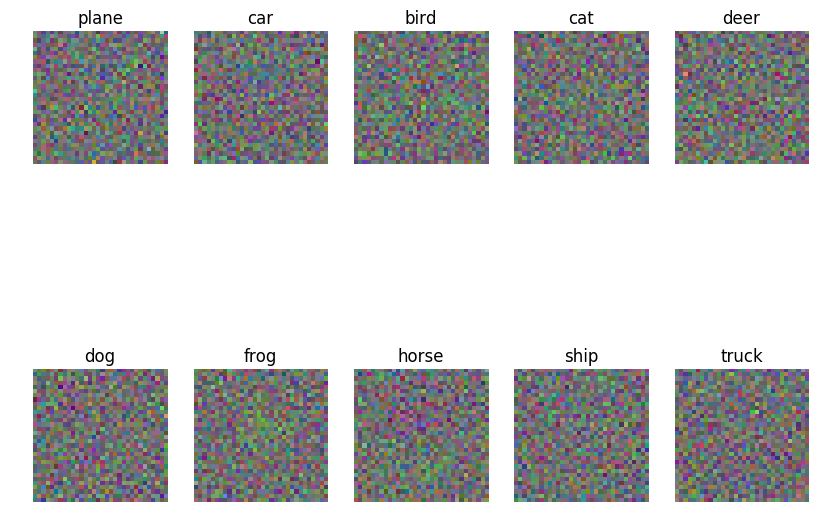

In [70]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])